# Unsupervised Learning
- **Principal Components Analysis**
    - A Simple Example
    - Computing the Principal Components
    - Interpreting Principal Components
    - Correspondence Analysis
- **K-Means Clustering**
    - A Simple Example
    - K-Means Algorithm
    - Interpreting the Clusters
    - Selecting the Number of Clusters
- **Hierarchical Clustering**
    - A Simple Example
    - The Dendrogram
    - The Agglomerative Algorithm
    - Measures of Dissimilarity
- **Model-Based Clustering**
    - Multivariate Normal Distribution
    - Mixtures of Normals
    - Selecting the Number of Clusters
- **Scaling and Categorical Variables**
    - Scaling the Variables
    - Dominant Variables
    - Categorical Data and Gower’s Distance
    - Problems with Clustering Mixed Data

**Aside:**

Unsupervised learning can play an important role in prediction, both for regression and classification problems. In some cases, we want to predict a category in the absence of any labeled data. For example, we might want to predict the type of vegetation in an area from a set of satellite sensory data. Since we don’t have a response variable to train a model, clustering gives us a way to identify common patterns and categorize the regions.

Clustering is an especially important tool for the “cold-start problem.” In this type of problem, such as launching a new marketing campaign or identifying potential new types of fraud or spam, we initially may not have any response to train a model. Over time, as
data is collected, we can learn more about the system and build a traditional predictive model. But clustering helps us start the learning process more quickly by identifying population segments.

Unsupervised learning is also important as a building block for regression and classification techniques. With big data, if a small subpopulation is not well represented in the overall population, the trained model may not perform well for that subpopulation. With clustering, it is possible to identify and label subpopulations. Separate models can then be fit to the different subpopulations. Alternatively, the subpopulation can be represented with its own feature,
forcing the overall model to explicitly consider subpopulation identity as a predictor.

## Principal Components Analysis

Often, variables will vary together (covary), and some of the variation in one is actually duplicated by variation in another (e.g., restaurant checks and tips). Principal
components analysis (PCA) is a technique to discover the way in which numeric variables covary

Important key terms:
- **Principal component**
- **Loadings**
- **Screeplot**

## A Simple Example

For two variables $X_1$ and $X_2$ there are two principal components $Z_i(i=1,2)$:
$$
Z_i = w_{i,1}X_1+w_{i,2}X_2
$$

The weights $(w_{i,1}, w_{i,2})$ are known as the component loadings. The first principal component, $Z_1$, is the linear combination that best explains the total variation. The second principal component, $Z_2$, is orthogonal to the first and explains as much of the remaining variation as it can. 

In [2]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

In [5]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [6]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


The weights for CVX and XOM for the first principal component are –0.747 and
–0.665, and for the second principal component they are -0.665 and 0.747. How to
interpret this? The first principal component is essentially an average of CVX and
XOM, reflecting the correlation between the two energy companies. The second principal component measures when the stock prices of CVX and XOM diverge.

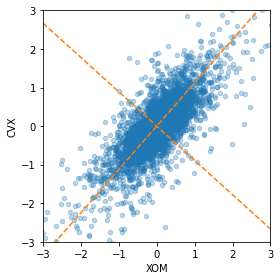

In [7]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

## Computing the Principal Components

The full process can be described as follows:

1. In creating the first principal component, PCA arrives at the linear combination of predictor variables that maximizes the percent of total variance explained.
2. This linear combination then becomes the first “new” predictor, $Z_1$.
3. PCA repeats this process, using the same variables with different weights, to create a second new predictor, $Z_2$. The weighting is done such that $Z_1$ and $Z_2$ are uncorrelated.
4. The process continues until you have as many new variables, or components, $Z_i$ as original variables $X_i$.
5. Choose to retain as many components as are needed to account for most of the variance.
6. The result so far is a set of weights for each component. The final step is to con‐ vert the original data into new principal component scores by applying the weights to the original values. These new scores can then be used as the reduced
set of predictor variables.

## Interpreting Principal Components

There are a couple of standard visualization displays to help you glean insight about the principal components. One such method is a screeplot to visualize the relative importance of principal components (the name derives from the resemblance of the plot to a scree slope; here, the y-axis is the eigenvalue)

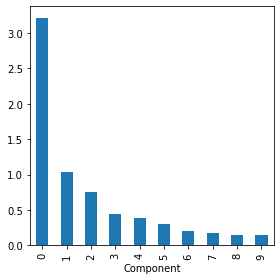

In [8]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [9]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

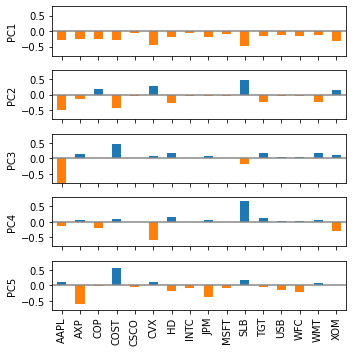

In [10]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

The loadings for the first principal component have the same sign: this is typical for data in which all the columns share a common factor (in this case, the overall stock market trend). The second component captures the price changes of energy stocks as compared to the other stocks. The third component is primarily a contrast in the movements of Apple and CostCo. The fourth component contrasts the movements of Schlumberger (SLB) to the other energy stocks. Finally, the fifth component is mostly dominated by financial companies.

### How Many Components to Choose?
If your goal is to reduce the dimension of the data, you must decide how many principal components to select. The most common approach is to use an ad hoc rule to select the components that explain “most” of the variance. You can do this visually through the screeplot. Alternatively, you could select the top components such that the cumulative variance exceeds a threshold, such as 80%. Also, you can inspect the loadings to determine if the component has an intuitive interpretation. Cross-validation provides a more formal method to select the number of significant components.

## Correspondence Analysis
Correspondence analysis is used mainly for graphical analysis of low-dimensional categorical data and is not used in the same way that PCA is for dimension reduction as a preparatory step with big data.


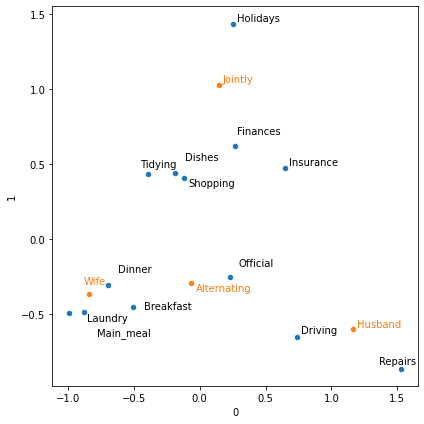

In [12]:
from adjustText import adjust_text

housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()
plt.show()

The output (after some matrix algebra) is a biplot—a scatterplot with axes scaled (and with percentages indicating how much variance is explained by that dimension). The meaning of the units on the axes is not intuitively connected to the original data, and the main value of the scatterplot
is to illustrate graphically variables that are associated with one another (by proximity
on the plot).

## K-Means Clustering

- **Cluster**
- **Cluster mean**
- **K**

K-means divides the data into K clusters by minimizing the sum of the squared distances of each record to the *mean* of its assigned cluster. This is referred to as the *within-cluster sum of squares or within-cluster SS*.

## A Simple Example

